<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
pip install prophet

     |████████████████████████████████| 13.0 MB 1.2 MB/s eta 0:00:01                    | 4.4 MB 1.2 MB/s eta 0:00:08
     |████████████████████████████████| 695 kB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 399 kB/s  eta 0:00:01
     |████████████████████████████████| 1.8 MB 57.6 MB/s eta 0:00:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.3.1
    Uninstalling holidays-0.11.3.1:
      Successfully uninstalled holidays-0.11.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from prophet import Prophet


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error as mse, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import datetime

In [3]:
RANDOM_STATE = 12345


In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df_resampled = df.resample('1H').sum()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [6]:
df_resampled.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [7]:
df_resampled.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

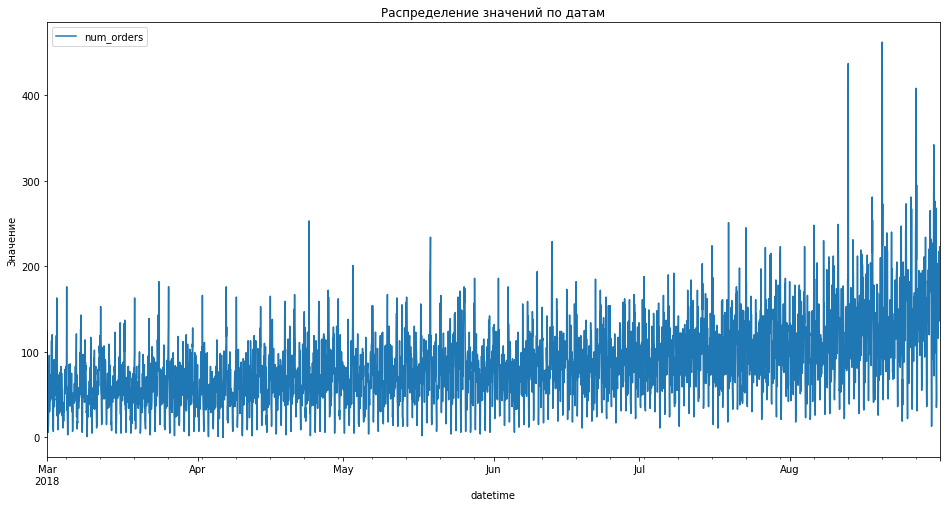

In [8]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение значений по датам')
ax.set_xlabel('Дата')
ax.set_ylabel('Значение')
df_resampled.plot(figsize=(16,8), ax=ax);

Динамика показвает что за последние полгода заказов такси становится больше

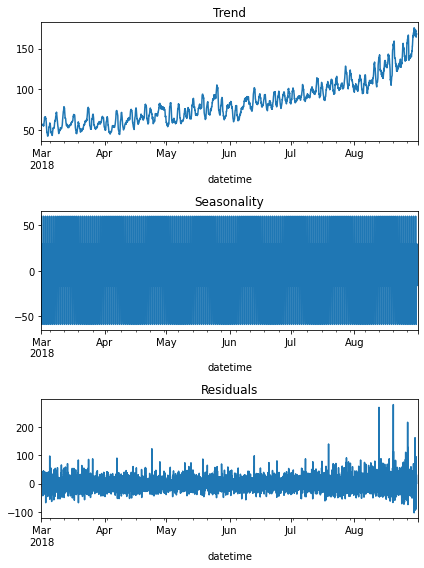

In [9]:
decomposed = seasonal_decompose(df_resampled) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Вывод 
Есть тренд повышения количества заказов за час
Сезонность сложно оценить по этому графику
Остатки не дают никаких выводов

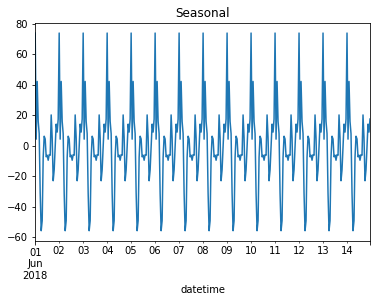

In [10]:
seasonal_decompose(df_resampled['2018-06-01':'2018-06-14']).seasonal.plot(title = 'Seasonal')
plt.show()

Можно заметить, что ночью заказывают мало такси, на утро идет повышение и к вечеру набирается пик. Я думаю обусловлено это тем что наибольшое колчество рейсов приходится на утро и вечер

In [11]:
print('Нулевая гипотеза: временной ряд нестационарен')
print('Альтернативная гипотеза: временной ряд стационарен')
result = adfuller(df_resampled, autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')


print('1%', (result[4]['1%']))
if result[0] < result[4]['1%']:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Нулевая гипотеза: временной ряд нестационарен
Альтернативная гипотеза: временной ряд стационарен
Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
1% -3.431842162413052
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


In [12]:
print('Нулевая гипотеза: временной ряд нестационарен')
print('Альтернативная гипотеза: временной ряд стационарен')
result = adfuller(df_resampled, autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')


print('5%', (result[4]['5%']))
if result[0] < result[4]['5%']:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Нулевая гипотеза: временной ряд нестационарен
Альтернативная гипотеза: временной ряд стационарен
Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
5% -2.8621993540813637
Нулевая гипотеза отвергнута – Временной ряд стационарен


Тесты показали разные результаты, оценим стационарность ряда с помощью сглаживания скользящим средним и последующей визуализацией сглаженного ряда на графике

In [15]:
df2 = df_resampled.copy()
df2['rolling_mean'] = df2.rolling(73, closed = 'left').mean()

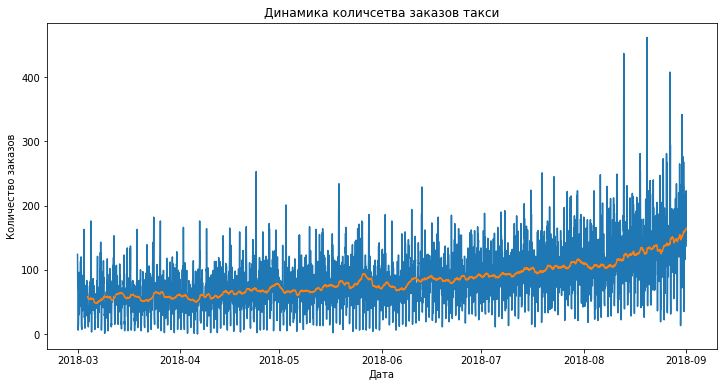

In [18]:
plt.figure(figsize=(12, 6)) 
plt.plot(df2)
plt.title("Динамика количсетва заказов такси") 
plt.xlabel("Дата")
plt.ylabel("Количество заказов") 
plt.show()

Как видим сглаженное среднее увеличивается со временем, значит ряд нестационарен

## Обучение

In [306]:
def rmse(predicted, target):
    return mse(predicted, target) ** 0.5

In [307]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [308]:
best_rmse = 1000

for q in range (1, 100):
    df_variant = make_features(df_resampled, 24, q)
    
    df_variant.dropna(inplace = True)
    
    features = df_variant.drop('num_orders', axis = 1)
    target = df_variant['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, shuffle = False)
    features_test, features_valid, target_test, target_valid = train_test_split(
        features_test, target_test, test_size=0.5, shuffle = False)
    model = LinearRegression()
    model.fit(features_train, target_train)

    model_pred = model.predict(features_valid)
        
    model_rmse = rmse(model_pred, target_valid)
    
    if model_rmse < best_rmse:
        best_rmse = model_rmse
        best_q = q

        
print('q:', best_q)
print("RMSE:", best_rmse)

q: 73
RMSE: 45.39410286549894


In [309]:
%%time

LINR = LinearRegression()

LINR.fit(features_train, target_train)

CPU times: user 21.4 ms, sys: 26.4 ms, total: 47.8 ms
Wall time: 83.5 ms


LinearRegression()

In [310]:
%%time
LINR_pred = LINR.predict(features_valid)

CPU times: user 16.3 ms, sys: 26.5 ms, total: 42.8 ms
Wall time: 82.3 ms


In [311]:
print("RMSE LINEAR", rmse(target_valid, LINR_pred))

RMSE LINEAR 45.5296318216962


In [312]:
rmsee = 10000
for depth in range(5,10 , 2):
    
    for iterations in range(20, 61, 20):
        
        model = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=RANDOM_STATE, iterations=iterations, max_depth = depth)
        model.fit(features_train, target_train)
        pred = model.predict(features_valid)
        result = rmse(target_valid, pred)
        if result < rmsee:
            depthh = depth
            iterationss = iterations
            rmsee = result
            best_cbr_model = model
print('RMSE:', rmsee)
print('Iterations:', iterationss)
print('depthh:', depth)

RMSE: 52.494455651076386
Iterations: 60
depthh: 9


In [313]:
df_resampled = df_resampled.rename(columns={'datetime ': 'ds','num_orders': 'y'})

In [314]:
df_resampled.reset_index(inplace= True )

In [315]:
df_resampled

,datetime,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


In [316]:
df_resampled['ds'] = df_resampled['datetime']
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  4416 non-null   datetime64[ns]
 1   y         4416 non-null   int64         
 2   ds        4416 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 103.6 KB


In [317]:
df_resampled = df_resampled.drop(columns = ['datetime'])

In [318]:
df_resampled

,y,ds
0,124,2018-03-01 00:00:00
1,85,2018-03-01 01:00:00
2,71,2018-03-01 02:00:00
3,66,2018-03-01 03:00:00
4,43,2018-03-01 04:00:00
...,...,...
4411,136,2018-08-31 19:00:00
4412,154,2018-08-31 20:00:00
4413,159,2018-08-31 21:00:00
4414,223,2018-08-31 22:00:00


In [319]:
df_train, df_test= train_test_split(
        df_resampled, test_size=0.2, shuffle = False)
df_test, df_valid= train_test_split(
        df_test, test_size=0.5, shuffle = False)

In [320]:
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')

In [321]:
model_prophet.fit(df_train)
future = model_prophet.make_future_dataframe(periods = len(df_valid))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5lmeii0_/ixfvgc50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5lmeii0_/6ewnwo9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40987', 'data', 'file=/tmp/tmp5lmeii0_/ixfvgc50.json', 'init=/tmp/tmp5lmeii0_/6ewnwo9y.json', 'output', 'file=/tmp/tmp5lmeii0_/prophet_modeldfapd5as/prophet_model-20230801190954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [322]:
forecast = model_prophet.predict(future)

In [323]:
len(forecast)

3974

In [324]:
d = forecast[3532:]

In [325]:
rmse(df_valid['y'], d['yhat'])

141.84426771686995

Вывод: 
Лучший результат показала линейная регрессия ее и выберем

## Тестирование

In [326]:
%%time
pred =LINR.predict(features_test)
print("RMSE LINR", rmse(target_test, pred))

RMSE LINR 34.48955432231521
CPU times: user 6.27 ms, sys: 14.9 ms, total: 21.1 ms
Wall time: 7.1 ms


In [327]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_train)
predictions_r_dummy = dummy_regr.predict(features_test)


In [328]:
print('Итоговое RMSE DummyRegressor', rmse(target_test, predictions_r_dummy))

Итоговое RMSE DummyRegressor 58.66529631032616


Линейная регрессия показала результат 34 что меньше константной модели и меньше 48. Значит наша модель адекватна и нас устраивает этот результат